In [1]:
import os
if "models" not in os.listdir("."):
    os.chdir("..")

In [2]:
%load_ext autoreload
%autoreload 2
import penzai
from penzai import pz
pz.ts.register_as_default()
pz.ts.register_autovisualize_magic()
pz.enable_interactive_context()

In [3]:
import jax_smi
jax_smi.initialise_tracking()

In [4]:
filename = "models/phi-3-16.gguf"
from micrlhf.llama import LlamaTransformer
llama = LlamaTransformer.from_pretrained(filename, device_map="auto")

In [5]:
from micrlhf.utils.vector_storage import download_vector
layer = 20

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")
tokenizer.padding_side = "right"

In [8]:
from micrlhf.utils.mmlu_eval import MMLUEval
mmlu_eval = MMLUEval()

1474 4422


In [9]:
resids = mmlu_eval.get_resids(llama, tokenizer, layer)

  0%|          | 0/4422 [00:00<?, ?it/s]

  0%|          | 0/1474 [00:00<?, ?it/s]

In [33]:
from micrlhf.utils.load_sae import get_sae
from sklearn.metrics import roc_auc_score
from more_itertools import chunked
import numpy as np
from matplotlib import pyplot as plt

def eval_mmlu(feat):
    if feat is None:
        vector_name = "phi3-sycophancy-l20"
        vector = download_vector(vector_name, overwrite=True)
    elif isinstance(feat, tuple):
        vector_name = f"phi3-sycophancy-l{feat[0]}-recon-r{feat[1]}"
        vector = download_vector(vector_name, overwrite=True)
    else:
        vector_name = f"l20r5 feature {feat}"
        vector = get_sae(20, 5)["W_dec"][feat]
    x = [[], []]
    N = len(mmlu_eval.incorrect_dataset)
    bs = 128
    resid = list(resids[:N]) + list(resids[N + bs - (N % bs):][:len(mmlu_eval.dataset)])
    for vec, correct in resid:
        x[correct].append(float(vec @ vector))
    incorrect = np.asarray(x[0])
    correct = np.asarray(x[1])
    # thresholds = np.linspace(-100, 100, 1000)
    labels = [np.ones_like(correct), np.zeros_like(incorrect)]
    roc_auc = max(roc_auc_score(np.concatenate(labels), np.concatenate([correct * s, incorrect * s])) for s in (1, -1))
    vecs, corrects = zip(*resid)
    vecs = np.asarray(vecs)
    corrects = np.asarray(corrects)
    correct_start_index = np.sum(corrects == 0)
    print(correct_start_index)
    indexer = []
    for i in range(0, correct_start_index, 3):
        indexer.append(i)
        indexer.append(i + 1)
        indexer.append(i + 2)
        indexer.append(correct_start_index + i // 3)
    vecs = vecs[indexer]
    corrects = corrects[indexer]
    accuracy1 = []
    accuracy2 = []
    for vecs_, corrects_ in zip(chunked(vecs, 4), chunked(corrects, 4)):
        scores = np.array([float(vec @ vector) for vec in vecs_])
        ans1 = np.argmax(scores)
        ans2 = np.argmin(scores)
        accuracy1.append(ans1 == np.argmax(corrects_))
        accuracy2.append(ans2 == np.argmax(corrects_))
    return roc_auc, max(np.mean(accuracy1), np.mean(accuracy2)), x, vector_name

4422
phi3-sycophancy-l20. Accuracy: 0.5848032564450475 ROC-AUC: 0.7912251220768


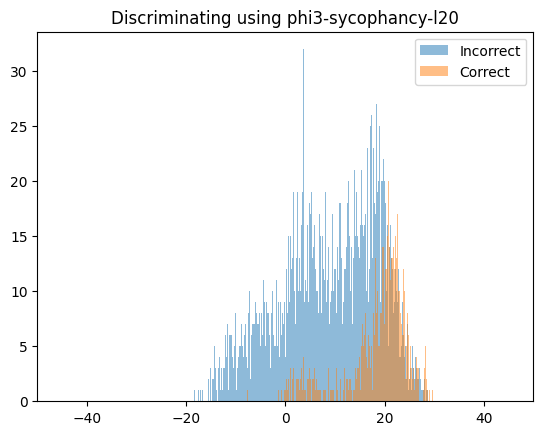

4422
phi3-sycophancy-l20-recon-r5. Accuracy: 0.5651289009497965 ROC-AUC: 0.7414663606845506


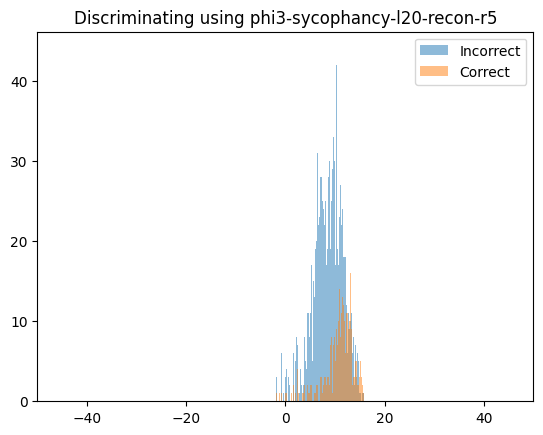

--2024-08-22 23:44:56--  https://huggingface.co/nev/phi-3-4k-saex-test/resolve/main/l20-test-run-5-7.00E-06/sae_weights.safetensors?download=true
Resolving huggingface.co (huggingface.co)... 108.157.142.50, 108.157.142.74, 108.157.142.53, ...
Connecting to huggingface.co (huggingface.co)|108.157.142.50|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.huggingface.co/repos/eb/d8/ebd889d6ac58573e8e8a7aa1176d4d357581a6da60135b94aca378fddf4e9e54/83ac196e9d76d5a3db26b4cc47737ff5c79d3cba0ce3954d02283b9331464948?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sae_weights.safetensors%3B+filename%3D%22sae_weights.safetensors%22%3B&Expires=1724629497&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNDYyOTQ5N319LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2ViL2Q4L2ViZDg4OWQ2YWM1ODU3M2U4ZThhN2FhMTE3NmQ0ZDM1NzU4MWE2ZGE2MDEzNWI5NGFjYTM3OGZkZGY0ZTllNTQvODNhYzE5NmU5

4422
l20r5 feature 15036. Accuracy: 0.5264586160108549 ROC-AUC: 0.7361749596657148


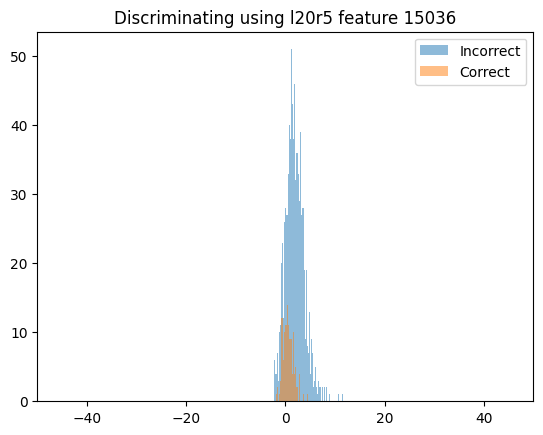

4422
l20r5 feature 45142. Accuracy: 0.5610583446404342 ROC-AUC: 0.6838309838497165


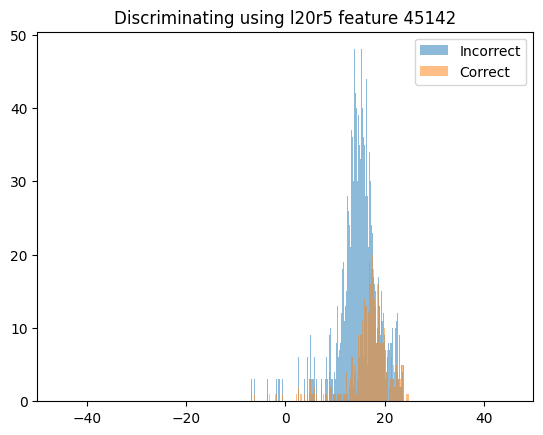

4422
l20r5 feature 42. Accuracy: 0.3100407055630936 ROC-AUC: 0.5460528092238941


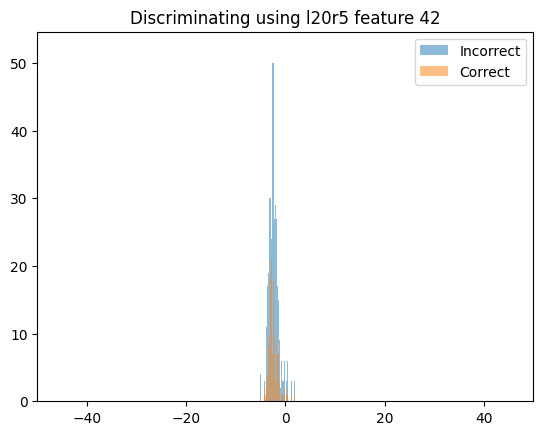

4422
l20r5 feature 9999. Accuracy: 0.505427408412483 ROC-AUC: 0.6698168525817931


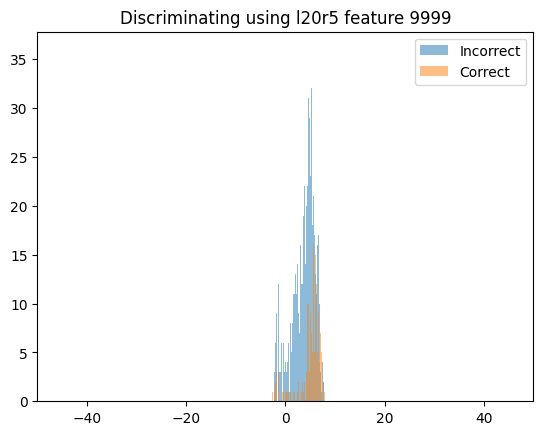

In [34]:
for feat in (9999, 42, 45142, 15036, (20, 5), None)[::-1]:
    roc_auc, accuracy, x, vector_name = eval_mmlu(feat)
    print(f"{vector_name}. Accuracy:", accuracy, "ROC-AUC:", roc_auc)
    plt.title(f"Discriminating using {vector_name}")
    plt.xlim(-50, 50)
    plt.hist(x[0], bins=500, alpha=0.5, label="Incorrect")
    plt.hist(x[1], bins=500, alpha=0.5, label="Correct")
    plt.legend()
    plt.show()

In [36]:
import numpy as np
w_dec = np.asarray(get_sae(20, 5)["W_dec"])
N = len(mmlu_eval.incorrect_dataset)
bs = 128
resid = list(resids[:N]) + list(resids[N + bs - (N % bs):][:len(mmlu_eval.dataset)])
vecs, corrects = zip(*resid)
vecs = np.asarray(vecs)
corrects = np.asarray(corrects)
correct_start_index = np.sum(corrects == 0)
print(correct_start_index)
indexer = []
for i in range(0, correct_start_index, 3):
    indexer.append(i)
    indexer.append(i + 1)
    indexer.append(i + 2)
    indexer.append(correct_start_index + i // 3)
vecs = vecs[indexer]
corrects = corrects[indexer]
resids_cpu = [[np.asarray(x), y] for x, y in resid]
def eval_mmlu_fast(feat):
    vector = w_dec[feat]
    x = [[], []]
    for vec, correct in resids_cpu:
        x[correct].append(float(vec @ vector))
    incorrect = np.asarray(x[0])
    correct = np.asarray(x[1])
    # thresholds = np.linspace(-100, 100, 1000)
    labels = [np.ones_like(correct), np.zeros_like(incorrect)]
    roc_auc = max(roc_auc_score(np.concatenate(labels), np.concatenate([correct * s, incorrect * s])) for s in (1, -1))
    accuracy1 = []
    accuracy2 = []
    for vecs_, corrects_ in zip(chunked(vecs, 4), chunked(corrects, 4)):
        scores = np.array([float(vec @ vector) for vec in vecs_])
        ans1 = np.argmax(scores)
        ans2 = np.argmin(scores)
        accuracy1.append(ans1 == np.argmax(corrects_))
        accuracy2.append(ans2 == np.argmax(corrects_))
    return roc_auc, max(np.mean(accuracy1), np.mean(accuracy2))


4422


In [38]:
from tqdm.auto import trange
roc_aucs = []
accuracies = []
for feat in trange(len(w_dec)):
    roc_auc, acc = eval_mmlu_fast(feat)
    roc_aucs.append(roc_auc)
    accuracies.append(acc)

  0%|          | 0/49152 [00:00<?, ?it/s]

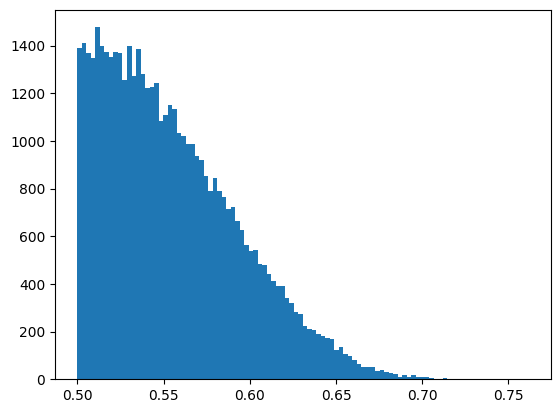

In [ ]:
plt.hist(roc_aucs, bins=100)
plt.show()
plt.hist(accuracies, bins=100)
plt.show()

In [40]:
(np.asarray(roc_aucs) >= 0.7099).sum(), (np.asarray(accuracies) >= 0.56).sum()

30

In [ ]:
feats = np.nonzero((np.asarray(accuracies) >= 0.56))[0].tolist()
sorted(feats, key=lambda x: roc_aucs[x], reverse=True)

In [41]:
feats = np.nonzero((np.asarray(roc_aucs) >= 0.7099))[0].tolist()
sorted(feats, key=lambda x: roc_aucs[x], reverse=True)

[39646,
 27474,
 16109,
 3634,
 11707,
 18103,
 13867,
 3842,
 7849,
 6226,
 8418,
 22713,
 47634,
 43052,
 14058,
 12569,
 30499,
 5892,
 31803,
 15065,
 29559,
 6488,
 43539,
 18364,
 15596,
 20793,
 10741,
 12997,
 259,
 15036]